# Support Vector Machines
Based on: Support Vector Machines in Python from Start to Finish. https://youtu.be/8A7L0GsBiLQ

## Import the modules





In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA

## Import the data
https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

### Attribute information:
This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:
- X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
- X2: Gender (1 = male; 2 = female).
- X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
- X4: Marital status (1 = married; 2 = single; 3 = others).
- X5: Age (year).
- X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
- X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
- X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.

In [27]:
df = pd.read_csv('default of credit card clients.csv')

df.rename({"default payment next month" : "DEFAULT"}, axis="columns", inplace = True)

df.drop("ID", axis = 1, inplace = True)

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_0      30000 non-null  int64
 6   PAY_2      30000 non-null  int64
 7   PAY_3      30000 non-null  int64
 8   PAY_4      30000 non-null  int64
 9   PAY_5      30000 non-null  int64
 10  PAY_6      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-null  int64
 21  PAY_AMT5   3

## Missing data
### Identifying missing data

In [34]:
df.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
DEFAULT      int64
dtype: object

In [36]:
df["SEX"].unique()

array([2, 1], dtype=int64)

Ok

In [38]:
df["EDUCATION"].unique()

array([2, 1, 3, 5, 4, 6, 0], dtype=int64)

Expected 1 - 4, 0 might be NAs and 5, 6 an unnamed category.

In [40]:
df["MARRIAGE"].unique()

array([1, 2, 3, 0], dtype=int64)

Expected 1 - 3, 0 might be NAs

Sklearn SVM does not support missing data

### Dealing with missing data

Rows with missing values:

In [49]:
len(df.loc[(df["EDUCATION"] == 0) | (df["MARRIAGE"] == 0 )])

68

In [46]:
len(df)

30000

Less than 1%, lets delete de data

In [50]:
df_no_missing = df.loc[(df["EDUCATION"] != 0) & (df["MARRIAGE"] != 0 )]
len(df_no_missing)

29932

## Downsample the dataset
SVM are great with small datasets, but may take a while using cross validations with big ones.
Lets leave 1000 rows for default and 1000 for not default.

In [55]:
df_no_default = df_no_missing[df_no_missing["DEFAULT"] == 0]
df_default = df_no_missing[df_no_missing["DEFAULT"] == 1]
len(df_no_default)
len(df_default)

6631

In [59]:
df_no_default_downsampled = resample(df_no_default,
                                     replace = False,
                                     n_samples=1000,
                                     random_state=42)

df_default_downsampled = resample(df_default,
                                     replace = False,
                                     n_samples=1000,
                                     random_state=42)

df_downsample = pd.concat([df_no_default_downsampled, df_default_downsampled])
len(df_downsample)

2000

## Format de Data
### Split into dependant and independant variables
Lets divide the dataset into "X" columns used form making predictions and "y" the colum to predict

In [61]:
X = df_downsample.drop(["DEFAULT"], axis = 1).copy()
X.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
641,130000,2,3,1,28,0,0,0,0,-2,...,50000,0,0,0,2500,1000,0,0,0,0
4678,170000,1,3,1,29,0,0,0,0,0,...,172307,35234,32869,33862,7200,7500,1200,1200,1500,1300
16004,180000,2,2,1,29,0,0,0,0,0,...,26310,26662,26166,26176,1800,1800,1500,1056,950,1000
22974,210000,2,2,2,32,-2,-2,-2,-2,-2,...,410,0,0,0,979,412,0,0,0,0
17535,190000,2,3,1,45,0,0,0,0,0,...,80548,81778,83082,84811,3300,3331,3359,2663,2751,3000


In [65]:
y = df_downsample["DEFAULT"].copy()
y.head()

641      0
4678     0
16004    0
22974    0
17535    0
Name: DEFAULT, dtype: int64

### One hot encoding
Sex, education, marriage and pay are supposed to be categorical values and need to be modified. SVM does not support categorical data as it does with continuous data. Lets do one hot encoding to turn this categorical data into multiple binary columns. For each category inside a feature we'll have a new column. Lets see an example using one hot enconding on MARRIAGE:

In [67]:
pd.get_dummies(X, columns=["MARRIAGE"]).head()

,LIMIT_BAL,SEX,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
641,130000,2,3,28,0,0,0,0,-2,-2,...,0,2500,1000,0,0,0,0,1,0,0
4678,170000,1,3,29,0,0,0,0,0,0,...,33862,7200,7500,1200,1200,1500,1300,1,0,0
16004,180000,2,2,29,0,0,0,0,0,0,...,26176,1800,1800,1500,1056,950,1000,1,0,0
22974,210000,2,2,32,-2,-2,-2,-2,-2,-2,...,0,979,412,0,0,0,0,0,1,0
17535,190000,2,3,45,0,0,0,0,0,0,...,84811,3300,3331,3359,2663,2751,3000,1,0,0


In [72]:
X_encoded = pd.get_dummies(X, columns = ["SEX",
                                         "EDUCATION",
                                         "MARRIAGE",
                                         "PAY_0",
                                         "PAY_2",
                                         "PAY_3",
                                         "PAY_4",
                                         "PAY_5",
                                        "PAY_6"])
X_encoded.head()                                 

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_5_7,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7
641,130000,28,100143,50456,50000,0,0,0,2500,1000,...,0,1,0,0,0,0,0,0,0,0
4678,170000,29,165027,168990,172307,35234,32869,33862,7200,7500,...,0,0,0,1,0,0,0,0,0,0
16004,180000,29,25781,26000,26310,26662,26166,26176,1800,1800,...,0,0,0,1,0,0,0,0,0,0
22974,210000,32,355,975,410,0,0,0,979,412,...,0,1,0,0,0,0,0,0,0,0
17535,190000,45,76433,78472,80548,81778,83082,84811,3300,3331,...,0,0,0,1,0,0,0,0,0,0


### Center and scaling
The Radial Basis Function (RBF) that we are using assumes that the data are centered and scaled. So as to avoid data leakage lets first divide our data in training and testing before normalizing.

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42,train_size=0.7)
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

## Build a preliminary Support Vector Machine

In [81]:
clf_svm = SVC(random_state=42)
clf_svm.fit(X_train_scaled, y_train)

SVC(random_state=42)

After training the model, lets see how its perform on the testing dataset and draw a confussion matrix:

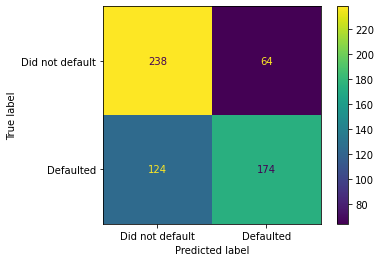

In [83]:
plot_confusion_matrix(clf_svm,
                      X_test_scaled,
                      y_test,
                      values_format="d",
                      display_labels=["Did not default", "Defaulted"])

Lets improve the results using cross validation.
## Optimize the parameters with CD and grid search
The two hyperparameters that can be optimized are gamma and C. Lets set the parameters of our random grid:

In [87]:
param_grid = [
    {"C" : [0.5, 1, 10, 100],
     "gamma" : ["scale", 1, 0.1, 0.01, 0.001, 0.0001],
     "kernel" : ["rbf"]},
]

optimal_params = GridSearchCV(
    SVC(),
    param_grid,
    cv = 5,
    scoring = "accuracy",
    verbose = 0
)

optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)


{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}


## Building, Evaluating, Drawing and Interpreting the final SVM

In [91]:
clf_svm = SVC(random_state=42, C = 1, gamma = 0.01)
clf_svm.fit(X_train_scaled, y_train)

SVC(C=1, gamma=0.01, random_state=42)

The new confusion matrix with the optimized values is:


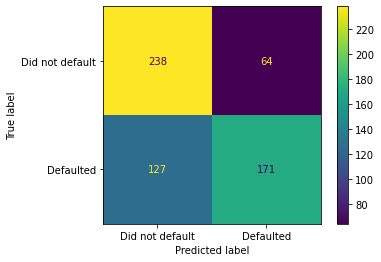

In [95]:
plot_confusion_matrix(clf_svm,
                      X_test_scaled,
                      y_test,
                      values_format="d",
                      display_labels=["Did not default", "Defaulted"])

As we can see, there wasnt a really major improvement from the benchmark. This is because SVM is pretty good straight out of the box without much optimizing.

If we want to have a graphic explanaition of the process well need principal component analysis since we have 24 columns.


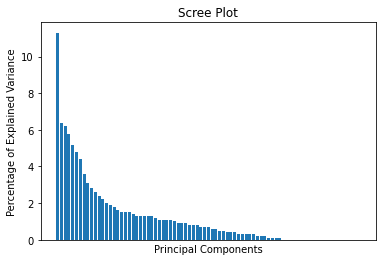

In [96]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = [str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1, len(per_var)+1), height=per_var)
plt.tick_params(axis='x', which = 'both', bottom=False, top=False, labelbottom=False)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

In [97]:
train_pc1_coords = X_train_pca[:, 0]
train_pc2_coords = X_train_pca[:, 1]

#Centering & Scaling
pca_train_scaled = scale(np.column_stack((train_pc1_coords, train_pc2_coords)))

param_grid = {'C':[0.5,0.1,1,10,100,1000], 'gamma':['scale', 1,0.1, 0.01,0.001,0.0001], 'kernel':['rbf']} 
# we including C=1 and gamma = 'scale' cause these are default values; 
# rbf = radial basis function, cause typically it gives us the best performance
# visit: Radial basis function https://en.wikipedia.org/wiki/Radial_basis_function
optimal_params = GridSearchCV(SVC(), param_grid, cv = 5, scoring='accuracy', verbose=0)

optimal_params.fit(pca_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}


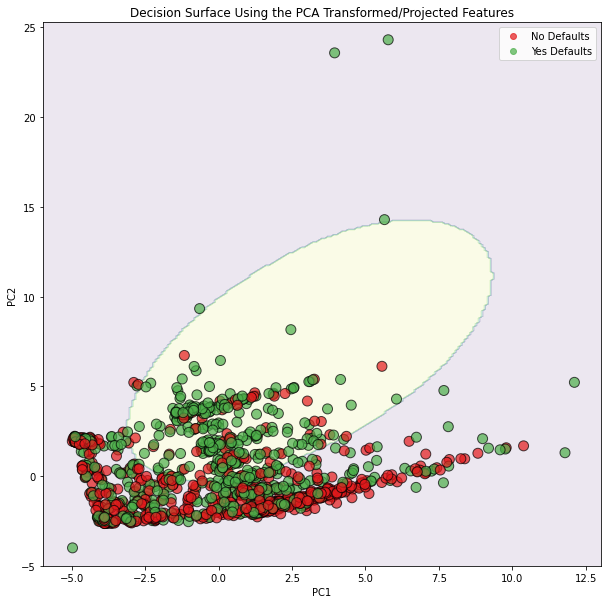

In [98]:
clf_svm = SVC(random_state=42, C=1000, gamma=0.001)
clf_svm.fit(pca_train_scaled, y_train)

X_test_pca = pca.transform(X_train_scaled)

test_pc1_coords = X_test_pca[:, 0]
test_pc2_coords = X_test_pca[:, 1]

x_min = test_pc1_coords.min()-1
x_max = test_pc1_coords.max()+1

y_min = test_pc2_coords.min()-1
y_max = test_pc2_coords.max()+1

xx, yy = np.meshgrid(np.arange(start=x_min, stop=x_max, step=0.1),np.arange(start=y_min, stop=y_max, step=0.1) )

Z = clf_svm.predict(np.column_stack((xx.ravel(), yy.ravel())))

Z = Z.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(10,10))

ax.contourf(xx,yy, Z, alpha=0.1)

cmap = colors.ListedColormap(['#e41a1c', '#4daf4a'])

scatter = ax.scatter(test_pc1_coords, test_pc2_coords, c=y_train, cmap=cmap, s=100, edgecolors='k', alpha=0.7)

legend = ax.legend(scatter.legend_elements()[0], scatter.legend_elements()[1], loc='upper right')

legend.get_texts()[0].set_text('No Defaults')
legend.get_texts()[1].set_text('Yes Defaults')

ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_title('Decision Surface Using the PCA Transformed/Projected Features')


#plt.savefig('svm_defaults.png)

plt.show()